# Ocular Diseases Classification using Deep Learning Techniques
## Project Overview
This project aims to develop a deep learning model for the classification of retinal images to identify various eye diseases. The focus is on four specific conditions: **Normal, Diabetic Retinopathy, Cataract, and Glaucoma**. 

By analyzing these images, we can assist in early diagnosis and treatment, ultimately improving patient outcomes.

## Dataset Description
The dataset used for this project comprises retinal images categorized into four classes:
* Normal: Healthy retinal images with no abnormalities
* Diabetic Retinopathy: Images showing signs of diabetic eye disease.
* Cataract: Images indicating the presence of cataracts in the lens of the eye.
* Glaucoma: Images that reveal signs of glaucoma, which affects the optic nerve.

Each class contains approximately 1,000 images, providing a balanced dataset for training and evaluation. The images have been sourced from various reputable databases, including:

* IDRiD: Indian Diabetic Retinopathy Image Dataset
* Ocular Recognition: A database focused on ocular disease recognition
* HRF: High-Resolution Fundus dataset

Source of Dataset:
*https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification/data*

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras_tqdm import TQDMNotebookCallback
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from powermanagement import long_running 

%autosave 30

Autosaving every 30 seconds


In [2]:
telltimefnx = lambda :print(f"Time Now: {pd.Timestamp.now().strftime('%Y.%m.%d %I:%M %p')}")
telltimefnx()

Time Now: 2024.10.25 09:03 PM


## Dataset Exploration
* Identification of number of samples for each category
* Creation of a unified dataframe, containing paths and respective category

In [3]:
dataPath = r"C:\Users\asuto\Desktop\Work\Eye Diseases\dataset"
os.listdir(dataPath)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [4]:
%%time
total = 0
for disease in os.listdir(dataPath):
    diseasePath = os.path.join(dataPath,disease)
    print(f"Number of samples for {disease} case: {len(os.listdir(diseasePath))}")
    total += len(os.listdir(diseasePath))
print(f"Total samples: {total}")

Number of samples for cataract case: 1038
Number of samples for diabetic_retinopathy case: 1098
Number of samples for glaucoma case: 1007
Number of samples for normal case: 1074
Total samples: 4217
CPU times: total: 31.2 ms
Wall time: 158 ms


In [5]:
%%time
diseaseMap = {"filepath":[],"label":[]}

for disease in tqdm(os.listdir(dataPath)):
    diseasePath = os.path.join(dataPath,disease)

    for path in os.listdir(diseasePath):
        diseaseMap['filepath'].append(os.path.join(dataPath,disease,path))
        diseaseMap['label'].append(disease)

opticDf = pd.DataFrame(diseaseMap).sample(frac=1)
opticDf.head()

100%|██████████| 4/4 [00:00<00:00, 115.88it/s]

CPU times: total: 78.1 ms
Wall time: 53.5 ms


,filepath,label
225,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,cataract
797,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,cataract
1276,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,diabetic_retinopathy
2978,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,glaucoma
1781,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,diabetic_retinopathy


In [6]:
opticDf.to_csv(r"C:\Users\asuto\Desktop\Work\Eye Diseases\opticDiseasesDataframe.csv",index=False)

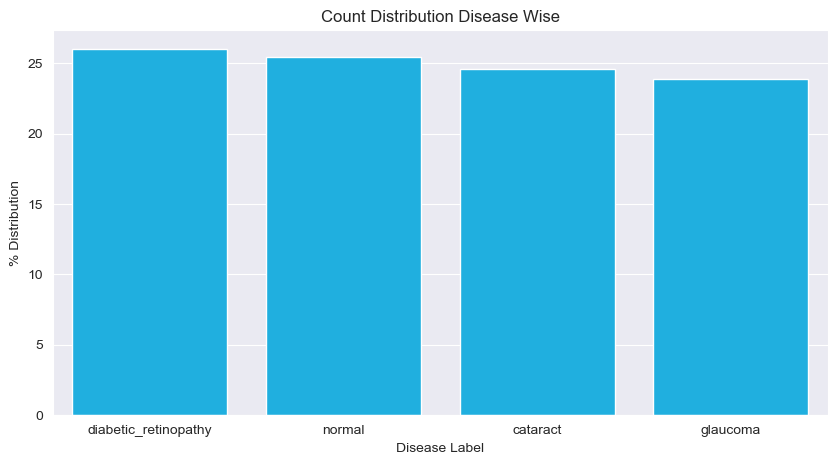

In [7]:
plt.figure(figsize=(10,5),dpi=100)
sns.barplot(opticDf.label.value_counts(normalize=True)*100,color='deepskyblue')
plt.xlabel("Disease Label")
plt.ylabel("% Distribution")
plt.title('Count Distribution Disease Wise')
plt.show()

## Image Exploration & Brief on Ocular Diseases
### Brief on Ocular Diseases
* **Normal:** Normal retinal images show a healthy eye without any issues. This is the baseline for comparison when looking for signs of disease.
* **Diabetic Retinopathy:** Diabetic Retinopathy is a condition that can happen in people with diabetes. It affects the blood vessels in the retina and can lead to vision problems. Early signs include tiny bulges and spots on the retina. If not caught early, it can worsen and cause serious vision loss.
* **Cataract:** Cataracts make the lens of the eye cloudy, which can blur vision. They are often related to aging but can also be caused by other factors like diabetes or eye injuries. People with cataracts may notice difficulty seeing at night or glare from bright lights. Surgery can help restore clear vision.

* **Glaucoma:** Glaucoma involves damage to the optic nerve, often due to high pressure in the eye. It can lead to vision loss if not treated. Many people don’t notice symptoms in the early stages, so regular eye check-ups are important for detection. There are different types, with open-angle glaucoma being the most common.

**Importance of Early Detection:**

Identification these diseases early is crucial to prevent vision loss. Regular eye exams can help identify problems before they become serious, making it important to analyze eye images for signs of these conditions.



In [8]:
def displayImg(sample,scaleImage = True):
    imgName,label = sample['filepath'].item().split('\\')[-1],sample['label'].item()
    path = sample['filepath'].item()
    img = mpimg.imread(path)

    if scaleImage:
        img = img / 255
        
    plt.figure(figsize= (6,6),dpi=80)
    imgplot = plt.imshow(img)
    plt.title(f"{imgName}:{label}",color= 'blue', fontsize= 12)
    plt.show()
    return img

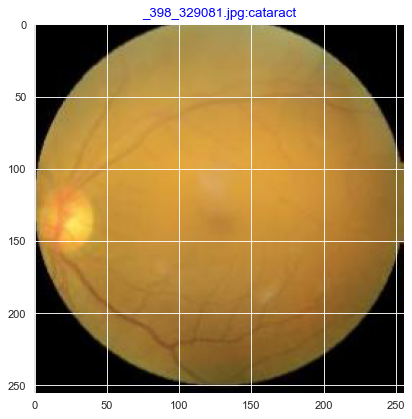

In [9]:
sample = opticDf.sample(1)
img = displayImg(sample)

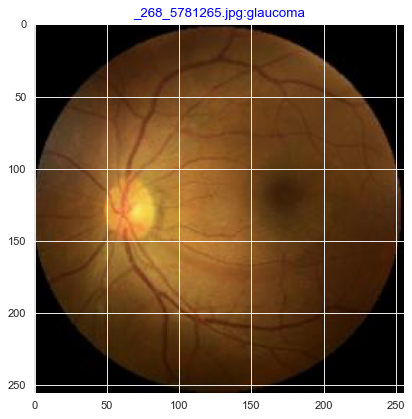

In [10]:
sample = opticDf.sample(1)
img = displayImg(sample)

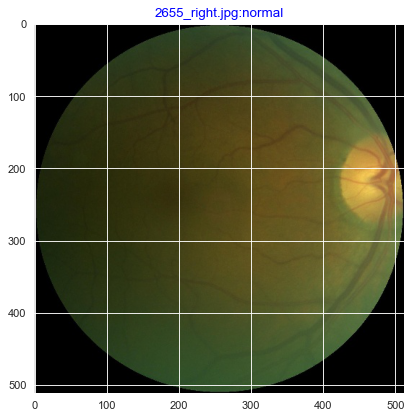

In [11]:
sample = opticDf.sample(1)
img = displayImg(sample)

In [12]:
print(img.shape)

(512, 512, 3)


---
## Data Splitting, Image Preprocessing and Generator

### Train Test Split
* Creation of Training, Validation and Testing Samples
* Splitting the dataframe into 70% Training, 15% Validation and 15% Testing datapoints.

In [13]:
opticDf.head()

,filepath,label
225,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,cataract
797,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,cataract
1276,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,diabetic_retinopathy
2978,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,glaucoma
1781,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,diabetic_retinopathy


In [14]:
#Creating Training Samples and a Dummy DF
trainSamples,dumSamples = train_test_split(opticDf,test_size=0.3,stratify=opticDf['label'])
#Creating Testing and Validation Samples from the Dummy DF
testSamples,validSamples = train_test_split(dumSamples,test_size=0.5,stratify=dumSamples['label'])

In [15]:
print("Training Data Size:", trainSamples.shape[0])
print("Validation Data Size:", validSamples.shape[0])
print("Testing Data Size:", testSamples.shape[0])

Training Data Size: 2951
Validation Data Size: 633
Testing Data Size: 633


### Image Generator
Preprocessing Steps:
* Image Resizing: Original (512,512) --> Standard (256,256)
* Image Standardization: IMG x (1/255)

**Image Resizing:**
Image resizing ensures all images have the same dimensions, which is essential for model compatibility and processing.

**Image Standardization:**
Image standardization ensures consistent pixel value distributions across all images, making it easier for the model to learn and perform well. By reducing the impact of lighting and contrast differences, it allows the model to focus on the actual patterns in the data.

In [16]:
img.shape

(512, 512, 3)

In [17]:
#Target Image Size. Original Image Size is (512,512)
imageSize = (256, 256)
color = 'rgb'
colorChannel = 3
imageShape = (imageSize[0],imageSize[1],colorChannel)
batch_size = 6

imgGen = ImageDataGenerator(rescale = 1/255)

In [18]:
trainGen = imgGen.flow_from_dataframe(trainSamples,x_col='filepath',y_col='label',class_mode='categorical',color_mode=color,target_size=imageSize,batch_size=batch_size)
valGen = imgGen.flow_from_dataframe(validSamples,x_col='filepath',y_col='label',class_mode='categorical',color_mode=color,target_size=imageSize,batch_size=batch_size)
testGen = imgGen.flow_from_dataframe(testSamples,x_col='filepath',y_col='label',class_mode='categorical',color_mode=color,target_size=imageSize,batch_size=batch_size)

Found 2951 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.


Image Shape after shape preprocessing: (256, 256, 3)



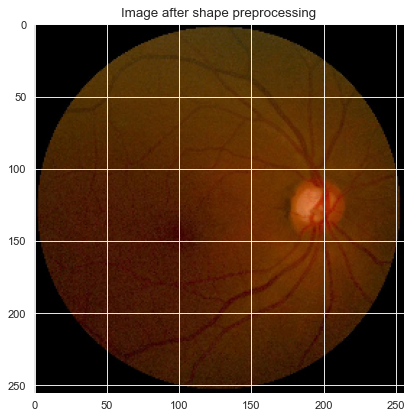

In [19]:
sampleImg = next(iter(trainGen))[0][0]
print(f"Image Shape after shape preprocessing: {sampleImg.shape}\n")

plt.figure(figsize= (6,6),dpi=80)
imgplot = plt.imshow(sampleImg)
plt.title("Image after shape preprocessing")
plt.show()

In [20]:
np.max(sampleImg),np.min(sampleImg)

(0.90196085, 0.0)

---
## Model Development
Using the power of Convolution and Convolutional Neural Networks

**Convolutional Neural Networks:**

Convolutional Neural Networks (CNNs) are a type of deep learning architecture designed for processing grid-like data, such as images. They utilize convolutional layers to automatically detect features like edges and textures by applying filters to the input. Pooling layers reduce the spatial dimensions, helping to maintain important information while lowering computational costs. CNNs typically include fully connected layers at the end for classification tasks. They are highly effective in tasks such as image recognition and object detection due to their ability to learn hierarchical features.

**Sample CNN Architecture**

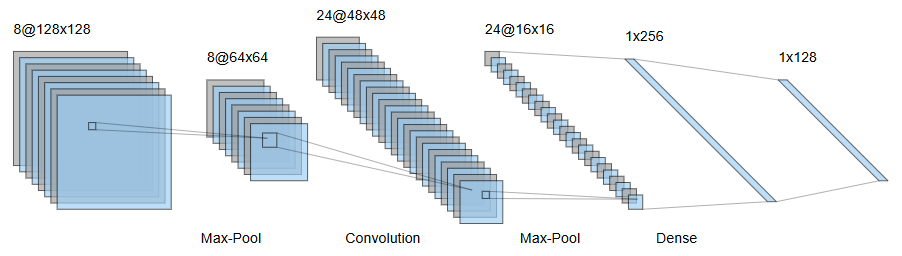

In [30]:
@long_running
def modelTrainingFnx(model,epochs,trainGen=trainGen,valGen=valGen,verbose=1):
    '''Verbose:0 = silent, 1 = progress bar, 2 = one line per epoch.'''
    tf.keras.backend.clear_session()
    # history = model.fit(x=trainGen,validation_data=valGen,epochs=epochs,verbose=0, callbacks=[TQDMNotebookCallback()])
    history = model.fit(x=trainGen,validation_data=valGen,epochs=epochs,verbose=verbose)
    return model,history 

In [22]:
def plotModelTraining(history):
    historyDf = pd.DataFrame(history.history).reset_index()
    historyDf['index'] += 1
    f, ax= plt.subplots(1, 2, sharey=False,figsize=(15,5),dpi=100)

    sns.lineplot(data=historyDf,x='index',y='loss',color='limegreen',ax=ax[0])
    sns.lineplot(data=historyDf,x='index',y='val_loss',color='red',ax=ax[0])
    sns.lineplot(data=historyDf,x='index',y='accuracy',color='limegreen',ax=ax[1])
    sns.lineplot(data=historyDf,x='index',y='val_accuracy',color='red',ax=ax[1])
    
    ax[0].set_title(f'Loss v/s Epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    
    ax[1].set_title(f'Accuracy v/s Epochs')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    plt.show()

---
### Custom Model 1

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,strides=(1,1),activation='relu',padding='same',input_shape=imageShape),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
model.summary()

#### Model Training

In [ ]:
%%time
telltimefnx()
model,history = modelTrainingFnx(model,epochs=10)
telltimefnx()

#### Loss Progression

In [ ]:
plotModelTraining(history)

#### Model Evaluation

In [ ]:
test_score = model.evaluate(testGen, steps= None, verbose= 1)

In [ ]:
print("Test Loss: ", test_score[0])
print(f"Test Accuracy: {(test_score[1])*100} %", )

In [ ]:
%%time
classes = list(testGen.class_indices.keys())
preds = model.predict(testGen)
yPred = np.argmax(preds, axis=1)

In [ ]:
print(classification_report(testGen.classes, yPred, target_names= classes))

In [ ]:
conf_matrix = confusion_matrix(testGen.classes, yPred,normalize='true')

plt.figure(figsize=(8,6),dpi=100)
ax = sns.heatmap(conf_matrix, annot=True,xticklabels=classes,yticklabels=classes,linewidths=0.5)
plt.xlabel("Predicted Diagnosis")
plt.ylabel("Actual Diagnosis")
plt.title("Confusion Matrix")
plt.show()

### Custom Model 2

In [23]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16,kernel_size=4,strides=(1,1),activation='relu',padding='same',input_shape=imageShape),
    tf.keras.layers.MaxPool2D(4),
    tf.keras.layers.Conv2D(filters=32,kernel_size=5,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(4),
    tf.keras.layers.Conv2D(filters=64,kernel_size=5,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(4),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

#### Model Training

In [25]:
%%time
telltimefnx()
model,history = modelTrainingFnx(model,epochs=50)
telltimefnx()

Time Now: 2024.10.02 11:40 PM
Epoch 1/50
492/492 [==============================] - 34s 54ms/step - loss: 1.2487 - accuracy: 0.3972 - val_loss: 0.8066 - val_accuracy: 0.5893
Epoch 2/50
492/492 [==============================] - 24s 50ms/step - loss: 0.8360 - accuracy: 0.5862 - val_loss: 0.7384 - val_accuracy: 0.6019
Epoch 3/50
492/492 [==============================] - 25s 50ms/step - loss: 0.7532 - accuracy: 0.6272 - val_loss: 0.6430 - val_accuracy: 0.7125
Epoch 4/50
492/492 [==============================] - 24s 49ms/step - loss: 0.6501 - accuracy: 0.6960 - val_loss: 0.6150 - val_accuracy: 0.7267
Epoch 5/50
492/492 [==============================] - 24s 49ms/step - loss: 0.6274 - accuracy: 0.7170 - val_loss: 0.6199 - val_accuracy: 0.7267
Epoch 6/50
492/492 [==============================] - 24s 48ms/step - loss: 0.6261 - accuracy: 0.7106 - val_loss: 0.6536 - val_accuracy: 0.7314
Epoch 7/50
492/492 [==============================] - 24s 48ms/step - loss: 0.6089 - accuracy: 0.7211 - va

#### Loss Progression

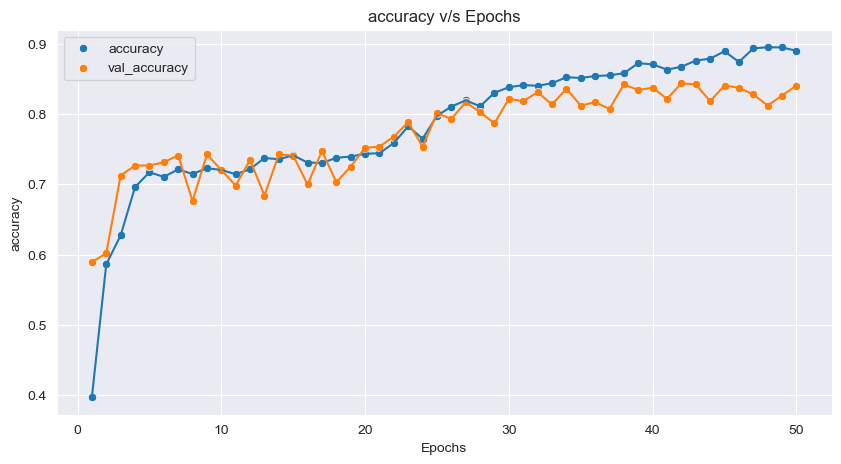

In [28]:
plotModelTraining(history)

#### Model Evaluation

In [29]:
test_score = model.evaluate(testGen, steps= None, verbose= 1)
print("Test Loss: ", test_score[0])
print(f"Test Accuracy: {(test_score[1])*100} %", )

106/106 [==============================] - 5s 44ms/step - loss: 0.7637 - accuracy: 0.8562
Test Loss:  0.7636518478393555
Test Accuracy: 85.62401533126831 %


In [30]:
%%time
classes = list(testGen.class_indices.keys())
preds = model.predict(testGen)
yPred = np.argmax(preds, axis=1)

print(classification_report(testGen.classes, yPred, target_names= classes))

106/106 [==============================] - 5s 41ms/step
                      precision    recall  f1-score   support

            cataract       0.22      0.26      0.24       156
diabetic_retinopathy       0.24      0.24      0.24       165
            glaucoma       0.24      0.18      0.21       151
              normal       0.24      0.25      0.25       161

            accuracy                           0.23       633
           macro avg       0.23      0.23      0.23       633
        weighted avg       0.23      0.23      0.23       633

CPU times: total: 6.02 s
Wall time: 4.96 s


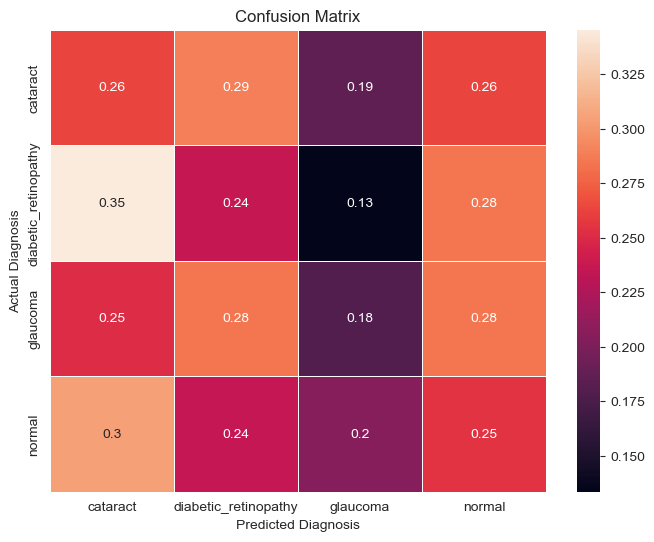

CPU times: total: 203 ms
Wall time: 260 ms


In [31]:
%%time
conf_matrix = confusion_matrix(testGen.classes, yPred,normalize='true')

plt.figure(figsize=(8,6),dpi=100)
ax = sns.heatmap(conf_matrix, annot=True,xticklabels=classes,yticklabels=classes,linewidths=0.5)
plt.xlabel("Predicted Diagnosis")
plt.ylabel("Actual Diagnosis")
plt.title("Confusion Matrix")
plt.show()

### AlexNet Architecture
* Added Data Augmentation
* Horizontal and Vertical Flips

In [23]:
%%time
#Target Image Size. Original Image Size is (512,512)
imageSize = (224, 224)
color = 'rgb'
colorChannel = 3
imageShape = (imageSize[0],imageSize[1],colorChannel)
batch_size = 64

imgGen = ImageDataGenerator(rescale = 1/255,horizontal_flip=True,vertical_flip=True,rotation_range=45)

trainGen = imgGen.flow_from_dataframe(trainSamples,x_col='filepath',y_col='label',class_mode='categorical',
                                      color_mode=color,target_size=imageSize,batch_size=batch_size)
valGen = imgGen.flow_from_dataframe(validSamples,x_col='filepath',y_col='label',class_mode='categorical',
                                    color_mode=color,target_size=imageSize,batch_size=batch_size)
testGen = imgGen.flow_from_dataframe(testSamples,x_col='filepath',y_col='label',class_mode='categorical',
                                     color_mode=color,target_size=imageSize,batch_size=batch_size)

Found 2951 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.
CPU times: total: 141 ms
Wall time: 146 ms


In [24]:
len(trainGen)

47

In [25]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=96,kernel_size=11,strides=(4,4),activation='relu',input_shape=imageShape),
    tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),
    
    tf.keras.layers.Conv2D(filters=256,kernel_size=5,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),
    
    tf.keras.layers.Conv2D(filters=384,kernel_size=3,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.Conv2D(filters=384,kernel_size=3,strides=(1,1),activation='relu',padding='same'),
    
    tf.keras.layers.Conv2D(filters=256,kernel_size=3,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128,activation='relu'), #added layer
    tf.keras.layers.Dense(4,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)       1

#### Model Training

In [27]:
%%time
telltimefnx()
model,history = modelTrainingFnx(model,epochs=3)
telltimefnx()

Time Now: 2024.10.15 05:46 PM
Epoch 1/3
47/47 [==============================] - 72s 1s/step - loss: 1.5796 - accuracy: 0.2928 - val_loss: 1.2807 - val_accuracy: 0.3318
Epoch 2/3
47/47 [==============================] - 59s 1s/step - loss: 1.2283 - accuracy: 0.4236 - val_loss: 1.1714 - val_accuracy: 0.5387
Epoch 3/3
47/47 [==============================] - 69s 1s/step - loss: 0.9597 - accuracy: 0.5683 - val_loss: 1.0654 - val_accuracy: 0.5577
Time Now: 2024.10.15 05:49 PM
CPU times: total: 3min 44s
Wall time: 3min 20s


#### Loss Progression

In [32]:
%%time
plotModelTraining(history)

NameError: name 'history' is not defined

#### Model Evaluation

In [ ]:
test_score = model.evaluate(testGen, steps= None, verbose= 1)
print("Test Loss: ", test_score[0])
print(f"Test Accuracy: {(test_score[1])*100} %", )


In [52]:
# model.predict(testGen)
yPred

array([3, 3, 3, 1, 0, 3, 2, 3, 1, 3, 0, 1, 0, 1, 0, 3, 3, 3, 3, 3, 2, 3,
       3, 3, 3, 0, 3, 3, 3, 0, 0, 1, 0, 2, 3, 0, 1, 3, 3, 3, 3, 3, 0, 1,
       2, 3, 1, 3, 3, 0, 1, 0, 0, 2, 3, 0, 1, 3, 0, 3, 0, 0, 3, 3, 1, 3,
       0, 1, 3, 1, 3, 1, 1, 3, 0, 2, 0, 1, 0, 3, 2, 2, 1, 3, 0, 1, 3, 3,
       3, 3, 1, 0, 3, 1, 3, 1, 3, 1, 1, 0, 0, 3, 1, 0, 2, 0, 3, 3, 3, 0,
       0, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 0, 3, 0, 1, 3, 1, 0, 3, 3, 3, 3,
       3, 3, 2, 0, 1, 3, 2, 1, 1, 1, 2, 0, 3, 0, 3, 0, 0, 0, 3, 0, 1, 0,
       1, 0, 3, 3, 3, 3, 3, 3, 2, 1, 3, 1, 0, 3, 0, 0, 0, 2, 3, 0, 1, 3,
       3, 0, 3, 3, 0, 0, 3, 3, 2, 1, 1, 1, 0, 3, 0, 2, 3, 1, 1, 1, 0, 0,
       0, 0, 3, 3, 3, 3, 3, 3, 2, 2, 1, 0, 3, 3, 3, 1, 1, 2, 3, 0, 1, 0,
       3, 0, 2, 0, 3, 0, 3, 0, 1, 3, 3, 1, 1, 1, 0, 1, 1, 1, 1, 1, 3, 1,
       3, 1, 1, 0, 0, 3, 0, 3, 3, 1, 0, 1, 3, 2, 1, 0, 1, 1, 3, 2, 1, 2,
       2, 0, 1, 0, 1, 1, 3, 0, 1, 0, 1, 3, 1, 0, 3, 1, 0, 3, 3, 1, 0, 0,
       1, 0, 1, 3, 3, 0, 0, 1, 1, 1, 3, 3, 0, 3, 2,

In [54]:
# testGen.labels

In [37]:
# model.predict(testGen[0][0][0])
# testGen[0][0][2].shape

In [38]:
testGen.class_indices.keys()

dict_keys(['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal'])

In [39]:
%%time
classes = list(testGen.class_indices.keys())
preds = model.predict(testGen)
yPred = np.argmax(preds, axis=1)

print(classification_report(testGen.classes, yPred, target_names= classes))

10/10 [==============================] - 10s 1s/step
                      precision    recall  f1-score   support

            cataract       0.29      0.31      0.30       156
diabetic_retinopathy       0.25      0.25      0.25       165
            glaucoma       0.25      0.09      0.13       151
              normal       0.25      0.39      0.31       161

            accuracy                           0.26       633
           macro avg       0.26      0.26      0.25       633
        weighted avg       0.26      0.26      0.25       633

CPU times: total: 12.5 s
Wall time: 11.5 s


In [41]:
preds

array([[1.6214553e-01, 2.5579133e-03, 1.5529139e-01, 6.8000519e-01],
       [1.9696066e-01, 3.3723295e-03, 1.6332385e-01, 6.3634318e-01],
       [1.6866799e-01, 4.6982323e-03, 1.5148343e-01, 6.7515039e-01],
       ...,
       [1.4075080e-04, 9.9851924e-01, 5.9164112e-04, 7.4847386e-04],
       [1.4075080e-04, 9.9851924e-01, 5.9164112e-04, 7.4847386e-04],
       [5.4757998e-05, 9.9880159e-01, 1.2221337e-04, 1.0213812e-03]],
      dtype=float32)

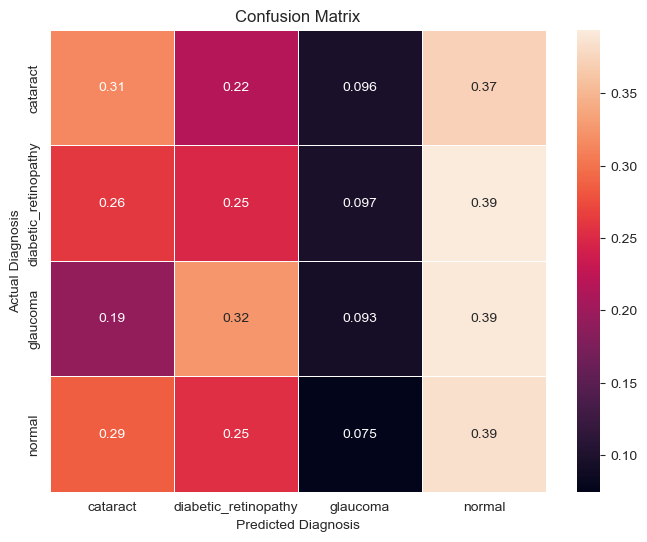

CPU times: total: 203 ms
Wall time: 202 ms


In [40]:
%%time
conf_matrix = confusion_matrix(testGen.classes, yPred,normalize='true')

plt.figure(figsize=(8,6),dpi=100)
ax = sns.heatmap(conf_matrix, annot=True,xticklabels=classes,yticklabels=classes,linewidths=0.5)
plt.xlabel("Predicted Diagnosis")
plt.ylabel("Actual Diagnosis")
plt.title("Confusion Matrix")
plt.show()

### Transfer Learning
* EfficientNetB3
* Added Data Augmentation
* Horizontal and Vertical Flips

In [24]:
%%time
#Target Image Size. Original Image Size is (512,512)
imageSize = (224, 224)
color = 'rgb'
colorChannel = 3
imageShape = (imageSize[0],imageSize[1],colorChannel)
batch_size = 64

imgGen = ImageDataGenerator(rescale = 1/255,horizontal_flip=True,vertical_flip=True,rotation_range=45)

trainGen = imgGen.flow_from_dataframe(trainSamples,x_col='filepath',y_col='label',class_mode='categorical',
                                      color_mode=color,target_size=imageSize,batch_size=batch_size)
valGen = imgGen.flow_from_dataframe(validSamples,x_col='filepath',y_col='label',class_mode='categorical',
                                    color_mode=color,target_size=imageSize,batch_size=batch_size)
testGen = imgGen.flow_from_dataframe(testSamples,x_col='filepath',y_col='label',class_mode='categorical',
                                     color_mode=color,target_size=imageSize,batch_size=batch_size)

Found 2951 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.
CPU times: total: 172 ms
Wall time: 159 ms


In [25]:
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= imageShape, pooling= 'max')

43941136/43941136 [==============================] - 1s 0us/step


In [28]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    tf.keras.layers.Dense(256, activation= 'relu'),
    tf.keras.layers.Dropout(rate= 0.4),
    tf.keras.layers.Dense(4, activation= 'softmax')
])

model.compile(tf.keras.optimizers.Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_2 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               393472    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_____________________________________

#### Model Training

In [31]:
%%time
telltimefnx()
model,history = modelTrainingFnx(model,epochs=3)
telltimefnx()

Time Now: 2024.10.25 09:11 PM
Epoch 1/3


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_2/efficientnetb3/block2a_expand_conv/Conv2D' defined at (most recent call last):
    File "C:\Users\asuto\miniconda3\envs\solar\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\asuto\miniconda3\envs\solar\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\asuto\miniconda3\envs\solar\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "C:\Users\asuto\miniconda3\envs\solar\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\asuto\miniconda3\envs\solar\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\asuto\miniconda3\envs\solar\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\asuto\AppData\Local\Temp\ipykernel_94972\1207290733.py", line 1, in <module>
      get_ipython().run_cell_magic('time', '', 'telltimefnx()\nmodel,history = modelTrainingFnx(model,epochs=3)\ntelltimefnx()\n')
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\IPython\core\interactiveshell.py", line 2493, in run_cell_magic
      result = fn(*args, **kwargs)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\IPython\core\magics\execution.py", line 1340, in time
      exec(code, glob, local_ns)
    File "<timed exec>", line 2, in <module>
    File "C:\Users\asuto\Desktop\Work\Eye Diseases\notebooks\powermanagement.py", line 28, in inner
      result = func(*args, **kwargs)
    File "C:\Users\asuto\AppData\Local\Temp\ipykernel_94972\3895918888.py", line 6, in modelTrainingFnx
      history = model.fit(x=trainGen,validation_data=valGen,epochs=epochs,verbose=verbose)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "C:\Users\asuto\miniconda3\envs\solar\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_2/efficientnetb3/block2a_expand_conv/Conv2D'
OOM when allocating tensor with shape[64,144,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_2/efficientnetb3/block2a_expand_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_37710]

#### Loss Progression

In [ ]:
%%time
plotModelTraining(history)

#### Model Evaluation

In [ ]:
test_score = model.evaluate(testGen, steps= None, verbose= 1)
print("Test Loss: ", test_score[0])
print(f"Test Accuracy: {(test_score[1])*100} %", )

In [ ]:
%%time
classes = list(testGen.class_indices.keys())
preds = model.predict(testGen)
yPred = np.argmax(preds, axis=1)

print(classification_report(testGen.classes, yPred, target_names= classes))

In [ ]:
%%time
conf_matrix = confusion_matrix(testGen.classes, yPred,normalize='true')

plt.figure(figsize=(8,6),dpi=100)
ax = sns.heatmap(conf_matrix, annot=True,xticklabels=classes,yticklabels=classes,linewidths=0.5)
plt.xlabel("Predicted Diagnosis")
plt.ylabel("Actual Diagnosis")
plt.title("Confusion Matrix")
plt.show()